In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.signal import fftconvolve
from scipy.fftpack import next_fast_len

##
## Dynamic Time-Evolving Template Matching (DTTM) and Farneback Optical Flow
graphcut output -> mask or segmented foreground of first frame -> dttm input

dttm output -> localized ROI (after object movement) -> optical flow input (for mask refinement) 

do looping inside of dttm; for now, test localization first, mask refinement later

In [35]:
template_bank = defaultdict(list)

In [39]:
def update_template_bank(image, mask, object_id, max_templates=5):
    """
    Crop the patch from the bounding rect of mask, mask out background pixels,
    and store the masked foreground patch in the template bank.
    """
    x, y, w, h = cv2.boundingRect(mask)

    # Crop image patch and convert to grayscale if needed
    patch = image[y:y+h, x:x+w]
    if len(patch.shape) == 3 and patch.shape[2] == 3:
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

    # Crop corresponding mask region and convert to binary mask (uint8)
    mask_patch = mask[y:y+h, x:x+w]
    if len(mask_patch.shape) == 3 and mask_patch.shape[2] == 3:
        mask_patch = cv2.cvtColor(mask_patch, cv2.COLOR_BGR2GRAY)
    _, mask_bin = cv2.threshold(mask_patch, 127, 255, cv2.THRESH_BINARY)
    mask_bin = mask_bin.astype(np.uint8)  # Just to be sure

    # Confirm sizes match
    assert patch.shape == mask_bin.shape, f"patch shape {patch.shape} vs mask shape {mask_bin.shape}"

    # Apply mask: keep foreground pixels only
    foreground = cv2.bitwise_and(patch, patch, mask=mask_bin)

    template_bank[object_id].append(foreground)

    if len(template_bank[object_id]) > max_templates:
        template_bank[object_id].pop(0)  # Remove oldest template


def match_and_localize(image, object_id, prev_bbox=None, search_margin=50):
    """
    Use OpenCV's matchTemplate for efficient template matching.
    Limits search area to a region around the previous bounding box.
    """
    print("[match_and_localize] Running template matching...")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h_img, w_img = gray.shape
    best_score = -1
    best_location = None
    best_template_size = None

    for idx, template in enumerate(template_bank[object_id]):
        th, tw = template.shape

        if prev_bbox:
            px, py, pw, ph = prev_bbox
            sx = max(0, px - search_margin)
            sy = max(0, py - search_margin)
            ex = min(w_img - tw, px + pw + search_margin)
            ey = min(h_img - th, py + ph + search_margin)
        else:
            sx, sy, ex, ey = 0, 0, w_img - tw, h_img - th

        search_region = gray[sy:ey, sx:ex]

        if search_region.shape[0] < th or search_region.shape[1] < tw:
            print(f"[match_and_localize] Skipping: search region too small for template {idx}.")
            continue

        result = cv2.matchTemplate(search_region, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        if max_val > best_score:
            best_score = max_val
            best_location = (sx + max_loc[0], sy + max_loc[1])
            best_template_size = (tw, th)

    if best_location is None:
        print("[match_and_localize] ❌ No good match found.")
        return None, best_score

    x, y = best_location
    w, h = best_template_size
    print(f"[match_and_localize] ✅ Match found: NCC={best_score:.3f} at ({x},{y})")
    return (x, y, w, h), best_score

def process_frame(frame, object_id=1, prev_bbox=None, init=False, template_threshold=0.7):
    """
    Track object via template matching.
    Optionally update the template bank based on appearance change.
    """
    print("[process_frame] Processing frame...")
    if init:
        t = template_bank[object_id][0]
        print("[process_frame] Initialization frame — no matching.")
        return cv2.rectangle(frame.copy(), (0, 0), (t.shape[1], t.shape[0]), (255, 0, 0), 2), (0, 0, t.shape[1], t.shape[0])

    match_bbox, score = match_and_localize(frame, object_id, prev_bbox)

    if match_bbox is None:
        print("[process_frame] Match failed, using previous bbox.")
        return frame, prev_bbox

    x, y, w, h = match_bbox

    if score < template_threshold:
        print(f"[process_frame] 🔁 Appearance changed (score={score:.3f}). Updating template.")
        mask_region = np.ones((h, w), dtype=np.uint8) * 255
        update_template_bank(frame, mask_region, object_id)
    else:
        print(f"[process_frame] ✅ Appearance consistent (score={score:.3f}). No update.")

    vis = frame.copy()
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return vis, (x, y, w, h)

def dynamic_template_matching(init_mask, video, output, first_frame, object_id=1):
    """
    Main tracking loop using dynamic template matching.
    """
    print("[dynamic_template_matching] Starting video tracking...")
    frame_idx = 0
    prev_bbox = None

    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            print("[dynamic_template_matching] End of video stream.")
            break

        if frame_idx == 0:
            print("[dynamic_template_matching] Initializing template from frame 0...")
            init_mask = init_mask.astype(np.uint8)
            if init_mask.ndim == 3:
                init_mask = cv2.cvtColor(init_mask, cv2.COLOR_BGR2GRAY)
            x, y, w, h = cv2.boundingRect(init_mask)
            # Crop frame and mask region
            frame_patch = frame[y:y+h, x:x+w]
            mask_patch = init_mask[y:y+h, x:x+w]

            update_template_bank(frame, init_mask, object_id)
            vis, prev_bbox = process_frame(frame, object_id=object_id, init=True)
        else:
            vis, prev_bbox = process_frame(frame, object_id=object_id, prev_bbox=prev_bbox)

        output.write(vis)
        cv2.imshow("Tracking", vis)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("[dynamic_template_matching] Tracking interrupted by user.")
            break

        frame_idx += 1

    print("[dynamic_template_matching] Releasing video resources.")
    video.release()
    output.release()


In [40]:
# === Configuration ===
video_path = "videos/clay.mp4"
output_path = "outputs/output_tracking.mp4"
object_id = 1  # Single-object tracking

# === Load video ===
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Could not open video: {video_path}")

# === Read the first frame ===
ret, first_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read first frame from video.")

# === Generate dummy initial mask for testing ===
init_mask = cv2.imread('outputs/segmented/clay_segmented.png')
if init_mask is None:
    raise FileNotFoundError("Could not load the mask image at 'outputs/segmented/clay_segmented.png'")

if len(init_mask.shape) == 3 and init_mask.shape[2] == 3:
    gray_mask = cv2.cvtColor(init_mask, cv2.COLOR_BGR2GRAY)
else:
    gray_mask = init_mask.copy()

_, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

x, y, w, h = cv2.boundingRect(binary_mask)
init_bbox = (x, y, w, h)

# === Define output writer ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_w, frame_h))

# Pass the first_frame explicitly here:
dynamic_template_matching(init_mask, cap, out, first_frame, object_id=object_id)

print("✅ Tracking complete. Output saved to:", output_path)
cv2.destroyAllWindows()

[dynamic_template_matching] Starting video tracking...
[dynamic_template_matching] Initializing template from frame 0...


AssertionError: patch shape (923, 973) vs mask shape (923, 979)

In [41]:
plt.imshow(template_bank[1][0], cmap='gray')
plt.title("Template 0 for object 1")
plt.axis('off')
plt.show()

IndexError: list index out of range

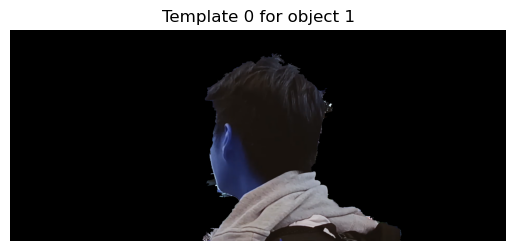

In [29]:
plt.imshow(init_mask, cmap='gray')
plt.title("Template 0 for object 1")
plt.axis('off')
plt.show()

In [ ]:
def mask_refinement():
    '''
    DO THIS LATER, TEST DTTM LOCALIZATION FIRST
    '''
    pass